In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import itertools
from sklearn.preprocessing import StandardScaler
import backtrader as bt
import pyfolio as pf
%matplotlib inline

In [73]:
class BaseStrategy(bt.Strategy):
    
    def __init__(self):
        pass
    
    def next(self):
        pass
    
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
        
    def log_candles(self):
        self.log('===>')
        self.log('Current Open: {}, Close: {}'.format(self.data0.open[0],self.data0.close[0]))
        self.log('Next Open: {}, Close: {}'.format(self.data0.open[1],self.data0.close[1]))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

# Rob Hanna strategy

In [146]:
class TestStrategy(BaseStrategy):
    def __init__(self):
        self.min20 = bt.indicators.Lowest(self.data0, period=20)
        self.sma200 = bt.indicators.SimpleMovingAverage(self.data0, period=200)
        
        self.first_cond = (self.min20 == self.data0.close)
        self.second_cond = (self.sma200 < self.data0.close)
        
    def next(self):
        if self.position and len(self) >= (self.buy_executed + 5):
            self.sell(exectype=bt.Order.Close)
            self.buy_executed = None
        
        is_monday = self.data.datetime.datetime(0).weekday() == 0
#         self.log('{} {}'.format(self.min20[0], self.sma200[0]))
        if self.first_cond and self.second_cond and is_monday:
            self.buy(exectype=bt.Order.Market)
            self.buy_executed = len(self)
            self.log_candles()

In [147]:
cerebro = bt.Cerebro()
cerebro.addstrategy(TestStrategy)

data = bt.feeds.YahooFinanceData(
    dataname='SPY',
    fromdate=datetime(2003,1,1),
    todate=datetime(2018,1,1),
    reverse=True)

cerebro.adddata(data)
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.broker.set_coc(True)
cerebro.addsizer(bt.sizers.PercentSizer, percents=50)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
results = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

Starting Portfolio Value: 100000.00
2004-03-22, ===>
2004-03-22, Current Open: 110.54, Close: 83.41
2004-03-22, Next Open: 110.25, Close: 83.26
2004-03-23, BUY EXECUTED, 83.41
2004-03-30, SELL EXECUTED, 85.93
2004-05-10, ===>
2004-05-10, Current Open: 109.44, Close: 82.79
2004-05-10, Next Open: 109.46, Close: 83.49
2004-05-11, BUY EXECUTED, 82.79
2004-05-18, SELL EXECUTED, 83.41
2004-07-19, ===>
2004-07-19, Current Open: 110.75, Close: 84.16
2004-07-19, Next Open: 110.53, Close: 85.23
2004-07-20, BUY EXECUTED, 84.16
2004-07-27, SELL EXECUTED, 83.81
2005-01-24, ===>
2005-01-24, Current Open: 117.09, Close: 90.04
2005-01-24, Next Open: 116.91, Close: 90.29
2005-01-25, BUY EXECUTED, 90.04
2005-02-01, SELL EXECUTED, 91.86
2005-03-21, ===>
2005-03-21, Current Open: 118.71, Close: 91.6
2005-03-21, Next Open: 118.37, Close: 90.66
2005-03-22, BUY EXECUTED, 91.60
2005-03-30, SELL EXECUTED, 91.66
2006-05-22, ===>
2006-05-22, Current Open: 126.28, Close: 99.55
2006-05-22, Next Open: 127.18, Close

Entire data start date: 2003-01-02
Entire data end date: 2017-12-29
Backtest months: 179


C:\DEV\Anaconda3\envs\trading\lib\site-packages\empyrical\stats.py:954: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


,Backtest
Annual return,0.5%
Cumulative returns,8.4%
Annual volatility,1.8%
Sharpe ratio,0.30
Calmar ratio,0.07
Stability,0.61
Max drawdown,-7.6%
Omega ratio,1.34
Sortino ratio,0.40
Skew,-5.87


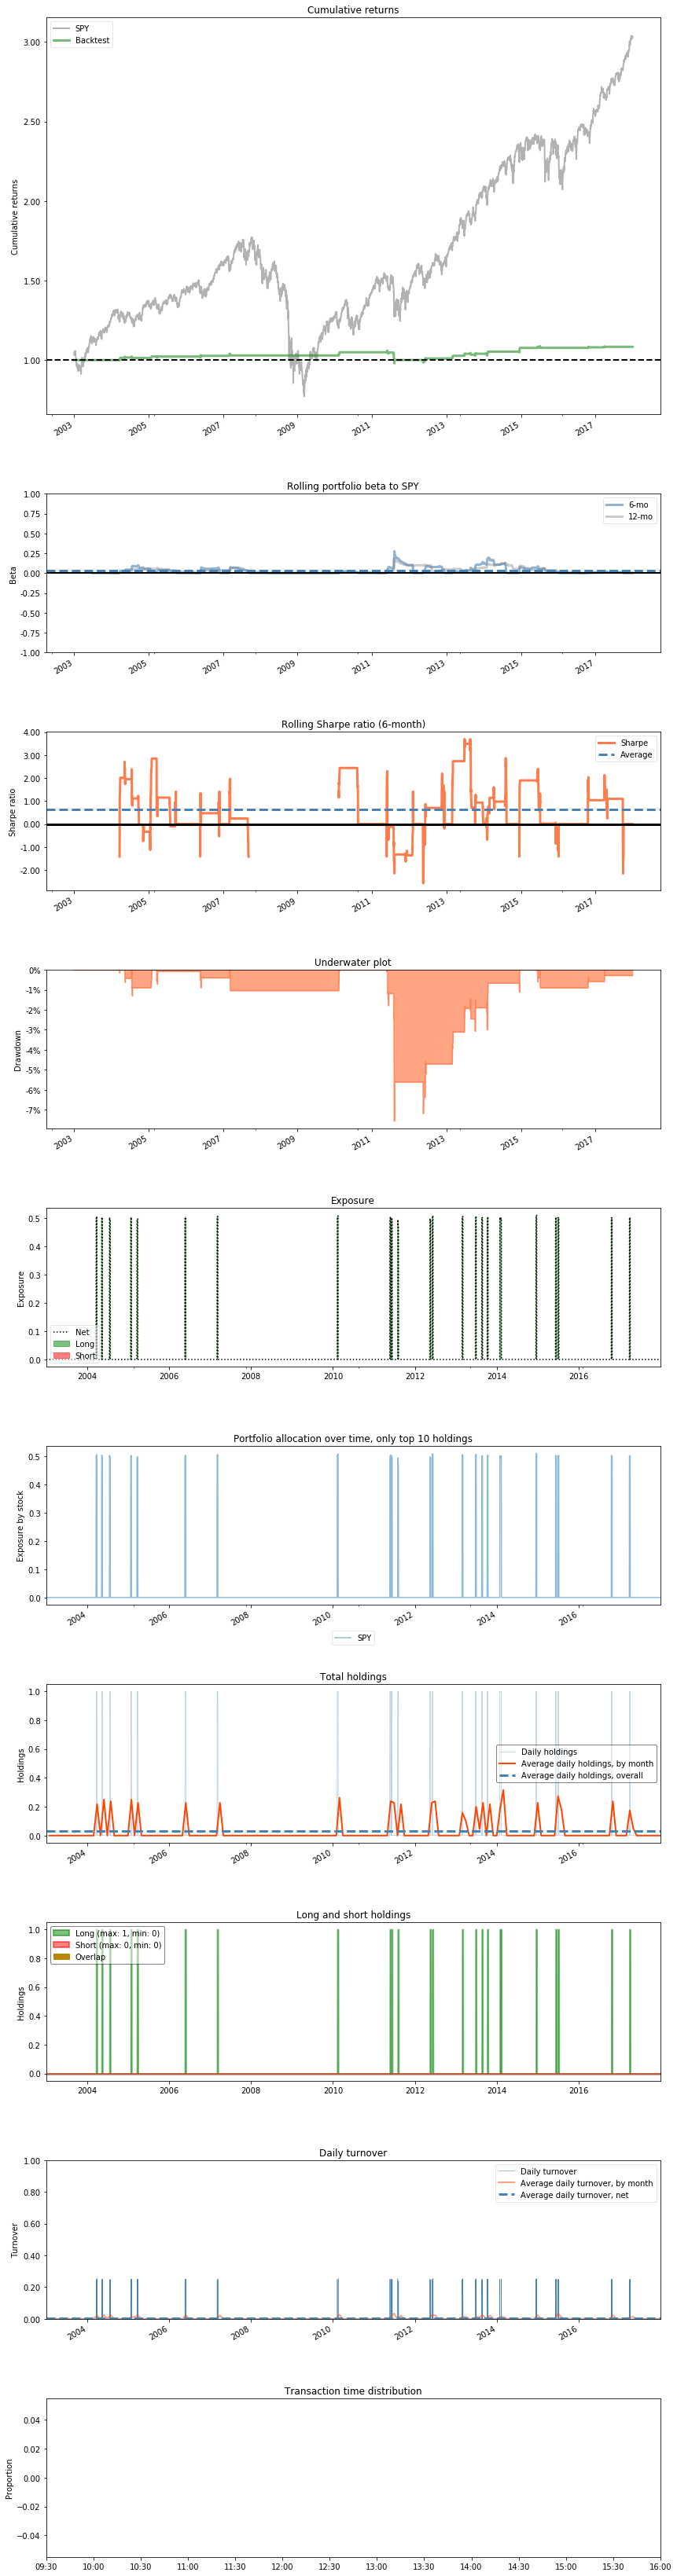

In [149]:
pf.create_simple_tear_sheet(returns=returns, 
                          positions=positions, 
                          transactions=transactions)